In [310]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from diffusers import UNet2DModel
from torch.utils.data import Subset
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Load Data

1875 32


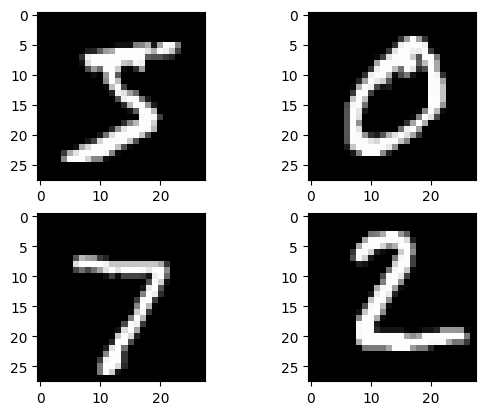

In [554]:

# download the MNIST dataset
transform = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.ToTensor()
])
train = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test = datasets.MNIST(root='./data', train=False, transform=transform, download=True)


# plot samples
num_samples = 2
sample_train = train.data[:num_samples]
sample_test = test.data[:num_samples]

fig, axs = plt.subplots(2, num_samples)
for i, sample in enumerate(sample_train):
    axs[0, i].imshow(sample.numpy(), cmap='gray')
for i, sample in enumerate(sample_test):
    axs[1, i].imshow(sample.numpy(), cmap='gray')

subset_size = int(1 * len(train))
indices = torch.randperm(len(train))[:subset_size]
train = Subset(train, indices)
subset_size = int(0.1 * len(test))
indices = torch.randperm(len(test))[:subset_size]
test = Subset(test, indices)    

train_loader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
print(len(train_loader), len(test_loader))

# Define Noising Function

In [555]:
def generate_noise_progression(alpha_t, X, times):
    assert times.shape[0] == X.shape[0]
    epsilon = torch.randn(X.shape).to(X.device) 
    alpha_hat_t = (alpha_t ** times).view(-1, 1, 1, 1)
    return torch.sqrt(alpha_hat_t) * X + (epsilon * torch.sqrt(1 - alpha_hat_t))

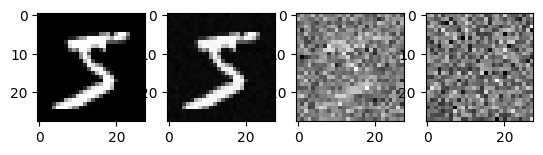

In [556]:
times = [0, 100, 500, 1000]
noised_sample = generate_noise_progression(0.99, sample_train[0].unsqueeze(0).repeat(len(times), 1,1, 1), torch.tensor(times))
fig, axs = plt.subplots(1, len(times))
for i, sample in enumerate(noised_sample):
    (axs[i].imshow
     (sample[0].numpy(), cmap='gray'))

# Define Model

In [557]:
model = (UNet2DModel(in_channels=1, 
                     out_channels=1, 
                     act_fn="gelu", 
                     block_out_channels=(32, 64, 96, 128),
                     down_block_types=(
                         "DownBlock2D",
                         "DownBlock2D",
                         "AttnDownBlock2D",
                         "DownBlock2D",
                     ),
                     up_block_types=(
                         "UpBlock2D",
                         "AttnUpBlock2D",
                         "UpBlock2D",
                         "UpBlock2D",
                     )
                    
                     ).to(device))

Iteration 0, Loss 0.212261363863945
Iteration 1, Loss 0.17486879229545593
Iteration 2, Loss 0.13588829338550568
Iteration 3, Loss 0.13282421231269836
Iteration 4, Loss 0.11574004590511322
Iteration 5, Loss 0.11053305119276047
Iteration 6, Loss 0.10275481641292572
Iteration 7, Loss 0.1060793399810791
Iteration 8, Loss 0.09475718438625336
Iteration 9, Loss 0.10045214742422104
Iteration 10, Loss 0.09138345718383789
Iteration 11, Loss 0.08170861750841141
Iteration 12, Loss 0.08089293539524078
Iteration 13, Loss 0.08983148634433746
Iteration 14, Loss 0.08152029663324356
Iteration 15, Loss 0.08003026247024536
Iteration 16, Loss 0.0839834213256836
Iteration 17, Loss 0.07708907872438431
Iteration 18, Loss 0.07181490957736969
Iteration 19, Loss 0.0712343081831932
Iteration 20, Loss 0.07246403396129608
Iteration 21, Loss 0.07596676796674728
Iteration 22, Loss 0.07054829597473145
Iteration 23, Loss 0.06911388039588928
Iteration 24, Loss 0.0666181743144989
Iteration 25, Loss 0.06781361997127533
It

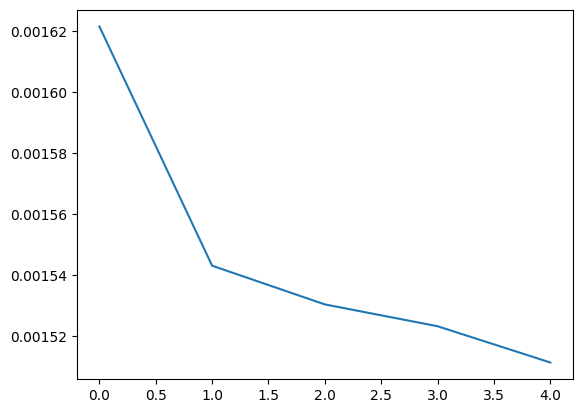

In [558]:
optimizer = optim.Adam(model.parameters(), lr=2e-4)
    
num_epochs = 5
T = 1000
alpha_t = 0.99

train_loss_evolution = []
for epoch in range(num_epochs):
    train_loss = 0
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)
        optimizer.zero_grad()
        times = torch.randint(2, T, size=(x.shape[0],)).to(device)
        noised_x = generate_noise_progression(alpha_t, x, times)
        x_hat = model(noised_x, times).sample
        
        loss = F.mse_loss(x_hat, x)
        train_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        print("Iteration {}, Loss {}".format(i, loss.item()))
    train_loss_evolution.append(train_loss / len(train))
    print(f'Epoch {epoch + 1} loss: {train_loss / len(train)}')
    
plt.plot(train_loss_evolution)
    
        
        
    

# Test

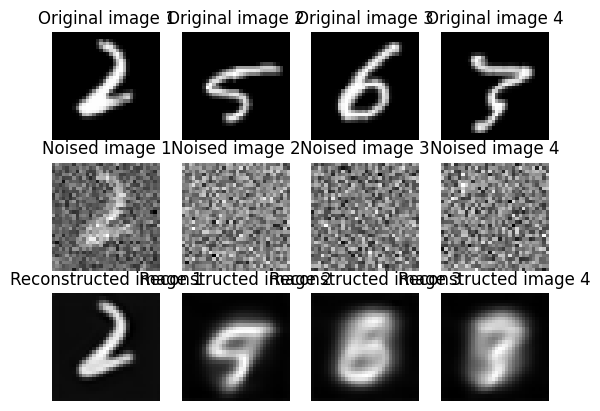

Iteration 0, Loss 0.026898032054305077
Iteration 1, Loss 0.026645198464393616
Iteration 2, Loss 0.025804955512285233
Iteration 3, Loss 0.02748740091919899
Iteration 4, Loss 0.02420262061059475
Iteration 5, Loss 0.02645326592028141
Iteration 6, Loss 0.026884473860263824
Iteration 7, Loss 0.03223218023777008
Iteration 8, Loss 0.0281980037689209
Iteration 9, Loss 0.026232926174998283
Iteration 10, Loss 0.024134360253810883
Iteration 11, Loss 0.025693681091070175
Iteration 12, Loss 0.0234159454703331
Iteration 13, Loss 0.02536458894610405
Iteration 14, Loss 0.026291580870747566
Iteration 15, Loss 0.02956853061914444
Iteration 16, Loss 0.028174158185720444
Iteration 17, Loss 0.025794928893446922
Iteration 18, Loss 0.02550949901342392
Iteration 19, Loss 0.025231478735804558
Iteration 20, Loss 0.017781702801585197
Iteration 21, Loss 0.027755646035075188
Iteration 22, Loss 0.024301839992403984
Iteration 23, Loss 0.023744486272335052
Iteration 24, Loss 0.025642389431595802
Iteration 25, Loss 0.

In [559]:
test_loss = 0
num_images = 4
fig, axs = plt.subplots(3, num_images)
model.eval()
for i, (x, _) in enumerate(test_loader):
    with torch.no_grad():
        x = x.to(device)
        times = torch.randint(2, T, size=(x.shape[0],)).to(device)
        noised_x = generate_noise_progression(alpha_t, x, times)
        x_hat = model(x, times).sample
        loss = F.mse_loss(x_hat, x)
        test_loss += loss.item()
        if i == 0:
            x = x.detach().cpu().squeeze()
            noised_x = noised_x.detach().cpu().squeeze()
            x_hat = x_hat.detach().cpu().squeeze()
            for idx, ax in enumerate(axs[0]):
                ax.imshow(x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Original image {idx + 1}')
            for idx, ax in enumerate(axs[1]):
                ax.imshow(noised_x[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Noised image {idx + 1}')
            for idx, ax in enumerate(axs[2]):
                ax.imshow(x_hat[idx], cmap='gray')
                ax.axis('off')
                ax.set_title(f'Reconstructed image {idx + 1}')
            plt.show()
    print("Iteration {}, Loss {}".format(i, loss.item()))
print(f'Test loss: {test_loss / len(test)}')
    

# Generate

In [560]:
generated_images = []
num_images = 100
with torch.no_grad():
    x_t = torch.randn([num_images, 1, 32, 32]).to(device)
    for t in reversed(range(2, T)):
        timestep = torch.tensor([t]).repeat(num_images).to(device)
        x_theta = model(x_t, timestep).sample
        alpha_bar_t = (alpha_t ** timestep).view(-1, 1, 1, 1)
        alpha_bar_t_1 = alpha_t ** (timestep-1).view(-1, 1, 1, 1)
        sqrt_alpha_t = torch.sqrt(torch.tensor(alpha_t).view(-1, 1, 1, 1)).to(device)
        mu_theta = 1 / (1 - alpha_bar_t) * (sqrt_alpha_t * (1 - alpha_bar_t_1) * x_t + torch.sqrt(alpha_bar_t_1) * (1 - alpha_t) * x_theta)
        x_t = mu_theta + ((1 - alpha_t) * (1 - alpha_bar_t_1) / (1 - alpha_bar_t)) * torch.randn(num_images).view(-1, 1, 1, 1).to(device)
    generated_images = x_t.detach().cpu().squeeze().squeeze().numpy()

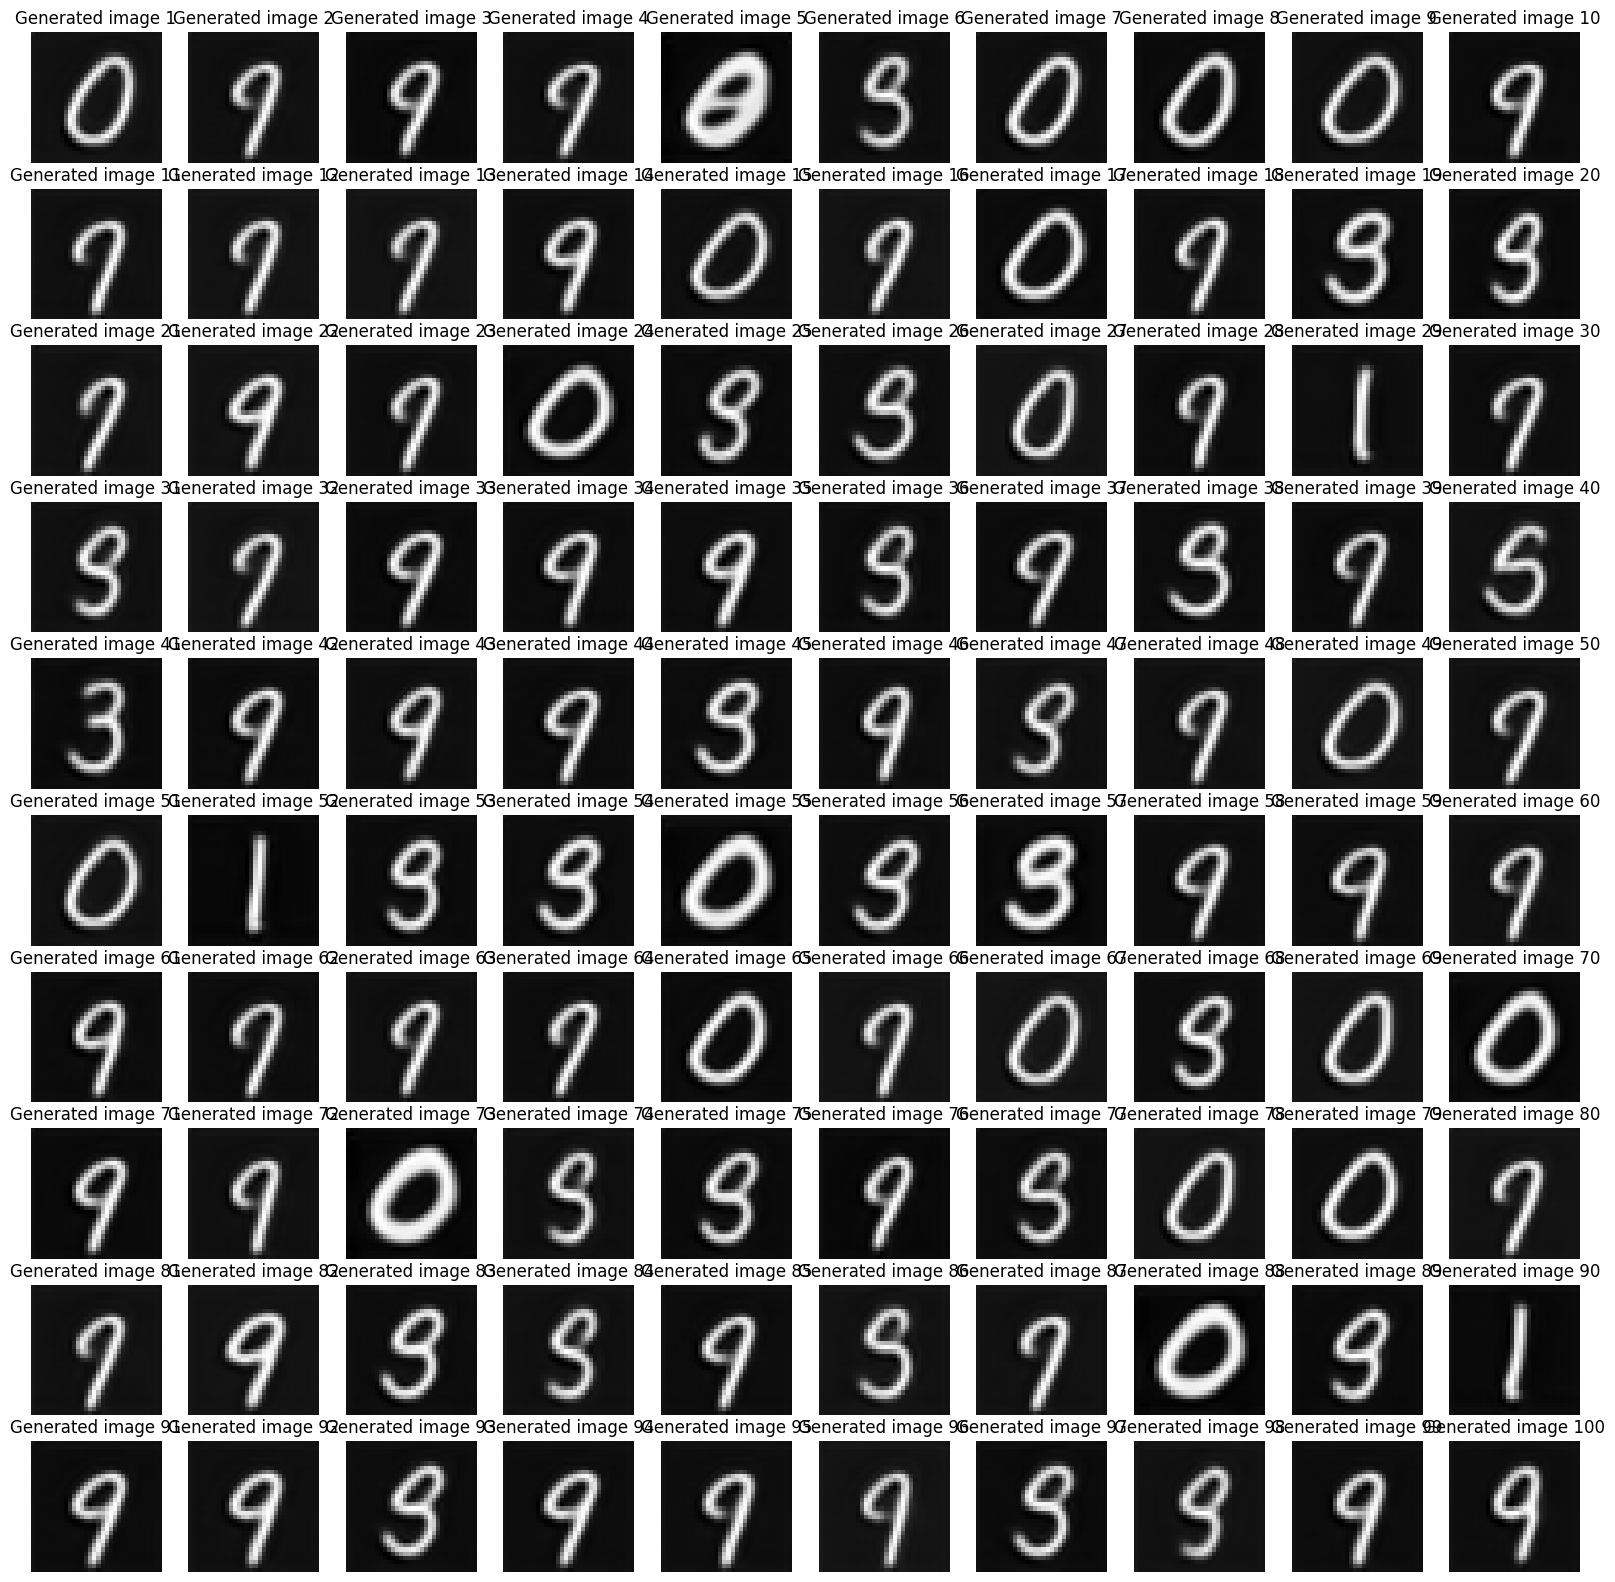

In [561]:
# Visualize the output

fig, axes = plt.subplots(nrows=10, ncols=int(num_images/10), figsize=(20, 20))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(f'Generated image {idx + 1}')
plt.show()